# Introduction

This is an atempt to understand and model the potential accessibility for a region on Portugal. 

In [1]:
# List of imports
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import pandana as pdna
import osmnx as ox
from pandana.loaders import osm
from shapely.geometry import Point
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Data
polygons = gpd.read_file('data/BGRI_2011/CONTINENTE/BGRI11_CONT.shp')

In [3]:
# selection method
def select_region(regionName, regionDTMN):
    region_selection = polygons[polygons['DTMN11']==regionDTMN]
    accessibility_selection = pd.read_csv('data/accessibility/'+regionName+'/accessibilityMean.csv', dtype={'key_0':str})
    accessibility_selection['key_0'] = accessibility_selection['key_0'].apply(lambda x: str(x).zfill(11))
    accessibility_selection = clean_accessibility_df(accessibility_selection)
    return region_selection, accessibility_selection

def clean_accessibility_df(access_df):
    access_df = access_df.rename(columns={'key_0':"BGRI",'1':'accessN1', '2':'accessN2', '3':'accessN3'})
    access_df = access_df.drop(columns=['Unnamed: 0'])
    return access_df

In [46]:
# Calculate Distance function, took from distance matrix program
def calculate_distance(point1, point2):
    """  
    Base function that actually solves the problem.
    Calculate the real distance between two points using the nearest node on global network.
    Parameters
    ----------
    point1 : Point
        geometry
    point2 : Point
        geometry

    Returns
    ----------
    distance : float
    
    """

    node1 = ox.distance.get_nearest_node(myNetwork, (point1.y, point1.x))
    node2 = ox.distance.get_nearest_node(myNetwork, (point2.y, point2.x))
    try:
        distance = nx.shortest_path_length(myNetwork, node1, node2, weight='length')
    except Exception as ex:
        print('Node {} not reachable from {}'.format(point1, point2))
        print(ex)
        distance = float('NaN')
    return distance


def get_network(shape_dataFrame):
    latlng_geom, _ = ox.projection.project_geometry(shape_dataFrame.geometry[1], crs={'init':'epsg:3763'}, to_latlong=True)
    network = ox.graph_from_polygon(latlng_geom, network_type='all_private')
    return network

## Main Logic

<AxesSubplot:>

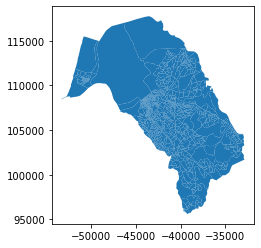

In [4]:
# Get Aveiro Polygons and Data
aveiro_polygons, aveiro_data = select_region('AVEIRO', '0105')
aveiro_polygons.plot()

In [5]:
aveiro_shape = aveiro_polygons[['geometry', 'DTMN11']].dissolve(by='DTMN11')
aveiro_shape = aveiro_shape.to_crs({'init':'epsg:4326'})

In [6]:
# Merge data to make plot easier
aveiro_polygons = pd.merge(aveiro_polygons[['BGRI11', 'geometry','area']], aveiro_data[['BGRI', 'accessN1','IQ']], how='left', left_on=[aveiro_polygons.BGRI11], right_on=[aveiro_data.BGRI])

<AxesSubplot:>

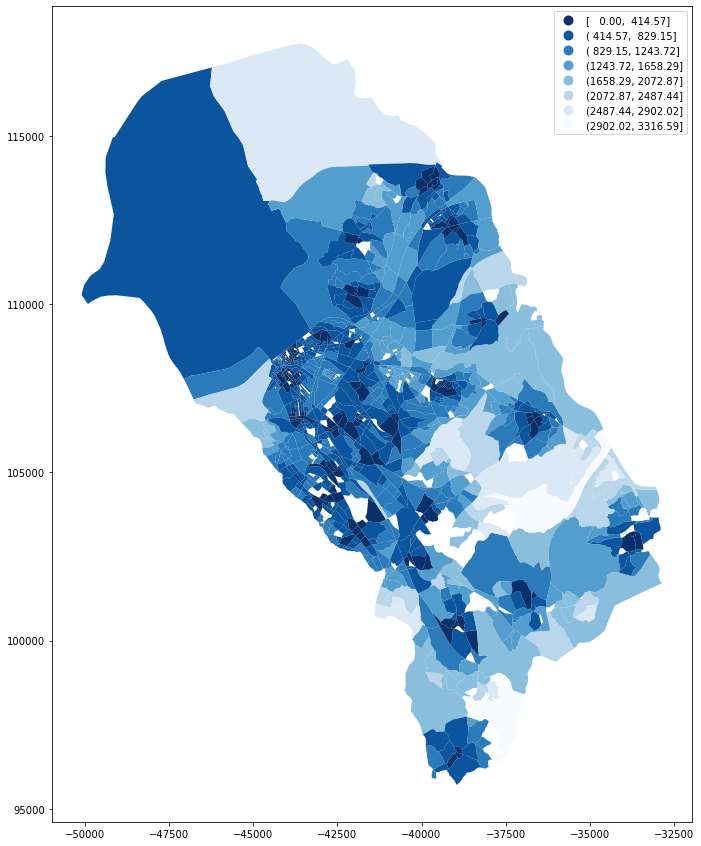

In [7]:
aveiro_polygons.dropna().plot(column='accessN1', cmap='Blues_r', figsize=(15,15), k=8, scheme='equal_interval', legend=True)

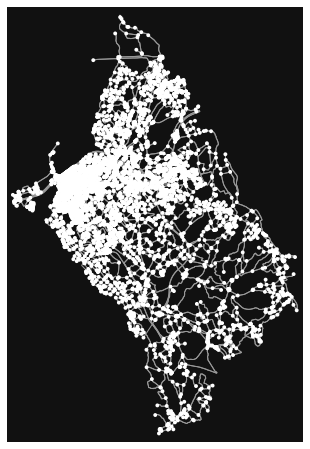

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [8]:
G = ox.graph_from_polygon(aveiro_shape.geometry[0])
ox.plot_graph(G)

## Ílhavo Logic

<AxesSubplot:>

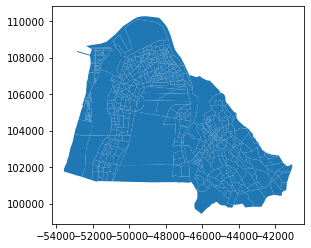

In [9]:
# Get Aveiro Polygons and Data
ilhavo_polygons, ilhavo_data = select_region('ÍLHAVO', '0110')
ilhavo_polygons.plot()

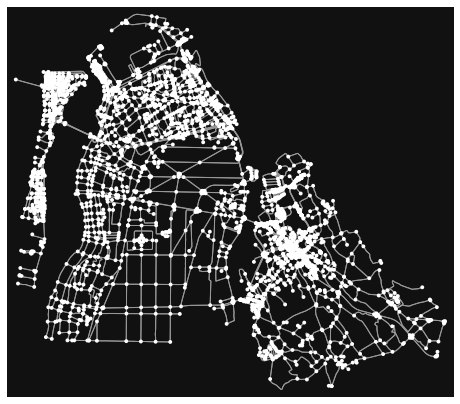

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [10]:
# Dissolve Polygons to get Shape
ilhavo_shape = ilhavo_polygons[['geometry', 'DTMN11']].dissolve(by='DTMN11')
ilhavo_shape = ilhavo_shape.to_crs({'init':'epsg:4326'})

# Get Urban Network using Desired Shape
G = ox.graph_from_polygon(ilhavo_shape.geometry[0])
ox.plot_graph(G)

In [11]:
#  Merge data to make plot easier
ilhavo_polygons = pd.merge(ilhavo_polygons[['BGRI11', 'geometry','area']], ilhavo_data[['BGRI', 'accessN1','IQ']], how='left', left_on=[ilhavo_polygons.BGRI11], right_on=[ilhavo_data.BGRI])

<AxesSubplot:>

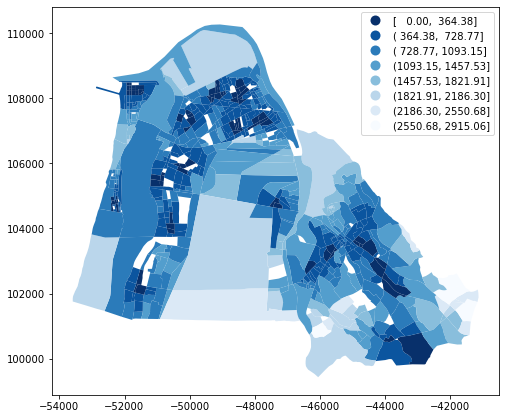

In [12]:
ilhavo_polygons.dropna().plot(column='accessN1', cmap='Blues_r', figsize=(8,8), k=8, scheme='equal_interval', legend=True)

In [13]:
# get all missing
ilhavo_missing = ilhavo_polygons[ilhavo_polygons.accessN1.isna()]

In [14]:
# Convert Missing to WSG-84 and get centroids
ilhavo_missing = ilhavo_missing.to_crs({'init':'epsg:4326'})
ilhavo_missing_centroids = ilhavo_missing.centroid

In [16]:
nx.

2      POINT (-8.70098 40.64272)
8      POINT (-8.70867 40.64239)
11     POINT (-8.70245 40.64263)
19     POINT (-8.74456 40.64327)
20     POINT (-8.74326 40.64329)
                 ...            
637    POINT (-8.73973 40.58952)
639    POINT (-8.63347 40.59113)
650    POINT (-8.72994 40.62288)
651    POINT (-8.73882 40.59812)
652    POINT (-8.73497 40.60018)
Length: 64, dtype: geometry

In [47]:
# Get Geometry shape
aveiro_ilhavo_polygon = polygons[(polygons['DTMN11']=='0105') | (polygons['DTMN11']=='0110')]
aveiro_ilhavo_polygon['temp'] = 1
aveiro_ilhavo_shape = aveiro_ilhavo_polygon.dissolve(by='temp')
# aveiro_ilhavo_shape = aveiro_ilhavo_shape.to_crs({'init':'epsg:4326'})

In [48]:
aveiro_ilhavo_network = get_network(aveiro_ilhavo_shape)

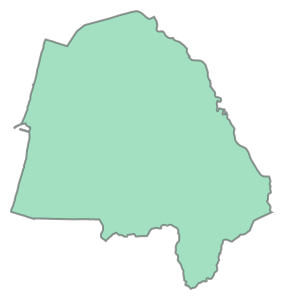

<Projected CRS: PROJCS["ETRS_1989_TM06-Portugal",GEOGCS["ETRS89",D ...>
Name: ETRS_1989_TM06-Portugal
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich